### Loading data
We create our data frames for test, train and validation <br>
We see that they contain 6 emotions: sadness, joy, fear, anger, love and surprise <br>
We create our dictionaries for turning emotion to id and id to emotion

In [34]:
import pandas as pd

def create_frame(filepath: str) -> pd.DataFrame:
  frame = pd.read_csv(filepath, sep=';', header=None)
  frame.columns = ['text', 'emotion']
  return frame

test_frame = create_frame('./data/test.txt')
train_frame = create_frame('./data/train.txt')
valid_frame = create_frame('./data/val.txt')

In [35]:
for text, emotion in test_frame.head().values:
  message = f'{text} -> {emotion}'
  print(message)

im feeling rather rotten so im not very ambitious right now -> sadness
im updating my blog because i feel shitty -> sadness
i never make her separate from me because i don t ever want her to feel like i m ashamed with her -> sadness
i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived -> joy
i was feeling a little vain when i did this one -> sadness


In [36]:
emotions = test_frame['emotion'].unique()
emotion_to_id, id_to_emotion = {}, {}
for id, emotion in enumerate(emotions):
  emotion_to_id[emotion] = id
  id_to_emotion[id] = emotion
emotion_to_id

{'sadness': 0, 'joy': 1, 'fear': 2, 'anger': 3, 'love': 4, 'surprise': 5}

### Vocabulary creation
Now, we wanna create a vocabulary containing words <br>
We wanna count each word occurence and draw a piechart of top 20 words

In [37]:
test_sentences, train_sentences, valid_sentences = test_frame['text'], train_frame['text'], valid_frame['text']
all_sentences = pd.concat([ test_sentences, train_sentences, valid_sentences ])
all_sentences.head()

0    im feeling rather rotten so im not very ambiti...
1            im updating my blog because i feel shitty
2    i never make her separate from me because i do...
3    i left with my bouquet of red and yellow tulip...
4      i was feeling a little vain when i did this one
Name: text, dtype: object

In [38]:
string_length = all_sentences.str.len()
mean_length = string_length.mean()
max_length = string_length.max()
print(f'Mean: {mean_length}, max: {max_length}')

Mean: 96.67005, max: 300


In [39]:
from collections import defaultdict

dictionary = defaultdict(int)
for sentence in all_sentences:
  words = sentence.split()
  for each in words:
    dictionary[each] += 1

dictionary = pd.DataFrame(dictionary.items())
dictionary.columns = ['word', 'count']
dictionary.head()

,word,count
0,im,3055
1,feeling,6431
2,rather,204
3,rotten,59
4,so,3127


In [40]:
import matplotlib.pyplot as plt

def get_top_words(frame: pd.DataFrame, amount: int = 10, len_threshold: int = 0) -> pd.DataFrame:
  long_words_mask = frame['word'].str.len() >= len_threshold
  long_words = frame.loc[long_words_mask]
  sorted_words = long_words.sort_values(by=['count'], ascending=False)
  top_words = sorted_words.head(amount)
  return top_words


In [41]:
import matplotlib.pyplot as plt

def draw_piechart(frame: pd.DataFrame) -> None:
  words, counts = frame['word'], frame['count']
  plt.pie(counts, labels=words)
  plt.title('Top 20 words')
  plt.show()

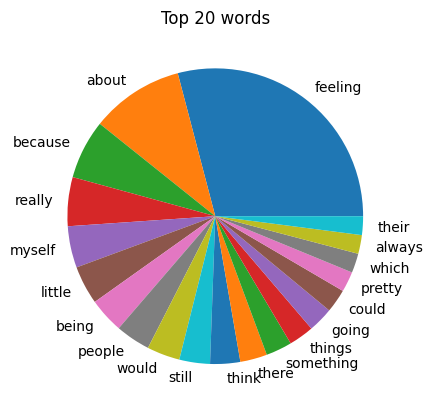

In [42]:
top_20_words = get_top_words(dictionary, 20, len_threshold=5)
draw_piechart(top_20_words)

### Now, let's create a mapping dictionary
This dictionary will map word -> unique index

In [43]:
from collections import defaultdict

mapping_dictionary = defaultdict(int)
top_words = get_top_words(dictionary, amount=10000)

for id, word in enumerate(top_words['word'].values):
  mapping_dictionary[word] = id


### We need to create a custom dataset class
Dataset selects row. Row contains a sentence and a label. <br>
Sentence -> tensor of word ids <br>
Label -> label id 

In [44]:
import torch
from torch.utils.data import Dataset
from torch.nn.functional import pad
import numpy as np

class EmotionDataset(Dataset):
  def __init__(self, frame: pd.DataFrame, word_mapping: dict[str, int], label_mapping: dict[str, int]) -> None:
    self.frame = frame
    self.word_mapping = word_mapping
    self.label_mapping = label_mapping
  
  def __len__(self) -> int:
    return len(self.frame)
  
  def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
    row = self.frame.iloc[index]
    text, label = row['text'], row['emotion']
    words = text.split()
    word_ids = map(lambda word: self.word_mapping[word], words)
    word_ids = np.fromiter(word_ids, dtype=np.int32)
    word_ids = torch.from_numpy(word_ids)
    word_ids = pad(word_ids, pad=(300 - len(word_ids), 0), mode='constant')
    label_id = self.label_mapping[label]
    return word_ids, label_id


### Creating our datasets
Train, test, validation 

In [45]:
train_dataset = EmotionDataset(train_frame, mapping_dictionary, emotion_to_id)
test_dataset = EmotionDataset(test_frame, mapping_dictionary, emotion_to_id)
valid_dataset = EmotionDataset(valid_frame, mapping_dictionary, emotion_to_id)

### Now, it's high time to build our neural network

So far I discovered three possible ways how to approach NLP learning <br>
From a perspective of Deep Learning:

1. RNN -- Recurrent Neural Network
2. LSTM -- Long Short Term Memory neural network (a variant of RNN)
3. Transformer -- superior architecture (ChatGPT uses Transformer btw)

As a starting point, I will proceed with building a simple RNN <br>
<br>



### Checking how to use embedding and RNN in PyTorch
Below I decided to experiment a little

In [46]:
import torch
from torch import nn

# load our word sequence of word IDs
words, _ = train_dataset[0]

# embedding -- turning word into vectors of size 100
embedding = nn.Embedding(len(mapping_dictionary), 100)
embedded = embedding(words)

# rnn 
rnn = nn.RNN(100, 128, 3)
_, hidden = rnn(embedded)

# flatten
flatten = nn.Flatten(0)
hidden = flatten(hidden)

hidden.unsqueeze(0).shape

torch.Size([1, 384])

In [47]:
import torch
from torch import nn

class EmotionRecognizerRNN(nn.Module):
  '''
  Recurrent Neural Network containing:
  - Embedding: turns words into vectors
  - Recurrent Multilayer Component: PyTorch RNN realization
  - Linear Layer: serving as an output layer
  - Softmax: for categorizing purposes
  '''
  def __init__(self, vocab_size: int) -> None:
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, 100)
    self.recurrent = nn.RNN(100, 128, 3, dropout=0.1, batch_first=True)
    self.linear = nn.Linear(128, 6)
    self.output_function = nn.Softmax(dim=1)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    embedded = self.embedding(x)
    _, hidden = self.recurrent(embedded)
    hidden = hidden[-1].unsqueeze(0)
    output = self.linear(hidden)
    return self.output_function(output)
    

### Setting up device and loaders
1. Select device (since I working on a Mac device, my choice is MPS)
2. Setup loaders for training, validating and testing

In [48]:
import torch

def select_device_type(debug: bool = False) -> str:
  if debug:
    return 'cpu'
  if torch.cuda.is_available():
    return 'cuda'
  if torch.backends.mps.is_available():
    return 'mps'
  if torch.backends.mkl.is_available():
    return 'mkl'
  return 'cpu'

def get_device(debug: bool = False) -> torch.device:
  device_type = select_device_type(debug)
  return torch.device(device_type)

In [49]:
def prompt_bool(message: str) -> bool:
  user_input = input(message).lower()
  return user_input == 'y' or user_input == 'yes'

debug = prompt_bool('Debug mode?')
device = get_device(debug)

device

device(type='cpu')

In [50]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
valid_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Writing a Trainer class
That class will be responsible for:
1. Evaluation
2. Training
3. Plotting validation history

In [51]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
from matplotlib import pyplot as plt

class Trainer:
  def __init__(self, model: nn.Module) -> None:
    self._model = model
    self.loss_function = nn.CrossEntropyLoss()
    self.optimizer = Adam(model.parameters(), lr=0.001)
    self._validation_history = []
  
  @property
  def validation_history(self) -> list[tuple[float, float]]:
    return self._validation_history
  
  # returns a validation history
  @property
  def validation_history(self) -> list[tuple[float, float]]:
    return self._validation_history
  
  # returns loss and accuracy
  def evaluate(self, loader: DataLoader) -> tuple[float, float]:
    loss, accuracy = 0.0, 0.0
    with torch.no_grad():
      for words, labels in loader:
        words, labels = words.to(device), labels.to(device)
        output = self._model(words)
        loss += self.loss_function(output, labels).item()
        predictions = output.argmax(dim=1)
        accuracy += (predictions == labels).sum().item()
    loss /= len(loader)
    accuracy /= len(loader.dataset)
    return loss, accuracy
  
  # trains the model
  def train(self, train_loader: DataLoader, valid_loader: DataLoader, epochs: int) -> None:
    for epoch in range(epochs):
      self._model.train()
      for words, labels in train_loader:
        words, labels = words.to(device), labels.to(device)
        self.optimizer.zero_grad()
        output = self._model(words)
        loss = self.loss_function(output, labels)
        loss.backward()
        self.optimizer.step()
      loss, accuracy = self.evaluate(valid_loader)
      self._validation_history.append((loss, accuracy))
      print(f'Epoch: {epoch + 1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
    
  # plots the validation history
  def plot_validation_history(self) -> None:
    losses, accuracies = zip(*self._validation_history)
    plt.plot(losses, label='Loss')
    plt.plot(accuracies, label='Accuracy')
    plt.legend()
    plt.show()


### Training, evaluating, saving...

In [52]:
model = EmotionRecognizerRNN(len(mapping_dictionary))
model = model.to(device)

In [53]:
trainer = Trainer(model)

In [54]:
trainer.train(train_loader, valid_loader, epochs=10)

ValueError: Expected input batch_size (1) to match target batch_size (64).